In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display as dp
import joblib
from hepler import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### 🎯 Notebook Goals:
1. Clean and aggregate application related supporting tables
- installment_df
- pos_cash_df
- credit_card_df
- previous_application_df
- bureau_df
- bureau_balance_df

2. Create features during aggregation.
3. Check the correlation between features.

For aggregation code detail, go to `data_aggregation.ipynb` notebook.

In [3]:
app_df = joblib.load("data/home-credit-default-risk/pkl_files/app_df")
app_train_ids = app_df.sk_id_curr.tolist()

In [ ]:
X = app_df.drop(columns=["target"])
y = app_df.target.values

X_train, X_val, y_app_train, y_app_val = train_test_split(
    X, y, stratify=y, random_state=0
)

### Pre-application related dataframes data aggregation and transformation

Rows in supporting dataframes: `instalment_df`, `credit_card_df`, and `pos_cash_df` \
were feature snapshots of the loan months or instalments. 

We can extract information out of them by transforming and aggregating the features. 

Here we would first aggregate features by sk_id_prev of the three dataframes \
to get record of `each individual previous record`.

#### instalment_df

contains snapshots of each instalment payment. 


In [5]:
inst_df = joblib.load("data/home-credit-default-risk/pkl_files/inst_df")
inst_agg_df = joblib.load("data/inst_agg_df")

##### Handle nulls and duplications

In [154]:
inst_df.duplicated().sum()

0

In [3]:
inst_df.isnull().sum()

sk_id_prev                   0
sk_id_curr                   0
num_instalment_version       0
num_instalment_number        0
days_instalment              0
days_entry_payment        2583
amt_instalment               0
amt_payment               2583
dtype: int64

The nulls in `days_entry_payment` and `amt_payment` occur simultaneously, \
as these 2 features are crucial for documenting the customer's payment \
and the imputed data would have higher risk to create bias, we would 
> drop the rows with missing data.

In [4]:
inst_df = inst_df.loc[~inst_df.isnull().any(axis=1)]

In [11]:
dp(inst_df.loc[inst_df.sk_id_prev == 2714724])

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
422906,2714724,167756,1.0,3,-1353.0,-1366.0,2165.040039,8.415000
1786772,2714724,167756,1.0,2,-1383.0,-1421.0,2165.040039,4.455000
2201494,2714724,167756,2.0,4,-1323.0,-1336.0,9691.290039,9691.290039
2843935,2714724,167756,1.0,1,-1413.0,-1421.0,2165.040039,2165.040039
2998490,2714724,167756,1.0,3,-1353.0,-1336.0,2165.040039,2156.625000


##### Aggregate features:

- `total_inst_count`: number of instalments.
- `full_paid_ratio`: ratio of instalment being fully paid.
- `delay_inst_ratio`: ratio of delayed instalment payment.
- `delay_total_days`: total delayed days of all payments.
- `delay_days_mean`: delayed days average.
- `total_payment`: sum of all payments.


In [10]:
dp(inst_agg_df.loc[inst_agg_df.sk_id_prev == 2714724])

,sk_id_prev,sk_id_curr,total_inst_count,fully_paid_ratio,delay_inst_ratio,delay_total_days,total_payment,total_pay_owe_diff,total_pay_owe_diff_ratio
795167,2714724,167756,4,1.0,0.5,34.0,16186.410156,0.0,0.0


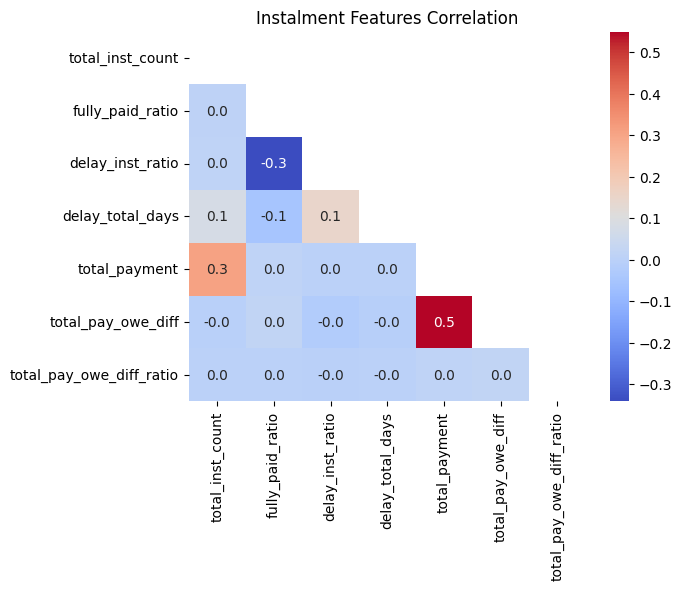

In [15]:
inst_corr = inst_agg_df.set_index("sk_id_curr").copy().drop(columns=["sk_id_prev"])
inst_corr = inst_corr.corr()
triangle_mask = np.triu(inst_corr)

sns.heatmap(inst_corr, cmap="coolwarm", annot=True, fmt="0.1f", mask=triangle_mask)
plt.title("Instalment Features Correlation")
plt.show()

---

#### pos_cash_df

contains snapshots of each monthly payment for cash loan. 

In [4]:
pos_df = joblib.load("data/home-credit-default-risk/pkl_files/pos_df")
pos_agg_df = joblib.load("data/pos_agg_df")

##### Handle nulls and duplications

In [155]:
pos_df.duplicated().sum()

0

In [13]:
pos_df.isnull().sum()

sk_id_prev                   0
sk_id_curr                   0
months_balance               0
cnt_instalment           21863
cnt_instalment_future    21878
name_contract_status         0
sk_dpd                       0
sk_dpd_def                   0
dtype: int64

the two features with nulls are not going to be used in data aggregation, thus \
they don't have to be dropped.

In [64]:
pos_df.loc[pos_df.sk_id_prev == 1773550].sort_values(
    by="months_balance").head()

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
8664174,1773550,412155,-64,6.0,6.0,Signed,0,0
5563814,1773550,412155,-63,6.0,5.0,Signed,0,0
5201937,1773550,412155,-62,6.0,4.0,Signed,0,0
5568669,1773550,412155,-61,6.0,3.0,Signed,0,0
9093206,1773550,412155,-60,6.0,2.0,Signed,0,0


##### Aggregate features:

- `total_months`: total months in months_balance
- `sk_dpd.sum`: sum of all delay days.
- `sk_dpd.mean`: mean of all delay days.
- `sk_dpd_def sum`: sum of all sk_dpd_def
- `sk_dpd_def mean`: mean of all sk_dpd_def
- `cnt_inst_org`: instalment count in the beginning
- `cnt_inst_changed`: instalment count changes
- `cnt_inst_decreases`: final instalment count is less than original one
- `contract_status`: ordinal mean of contract status, lower is better. \
(1: Completed, 2: Active, .., 4: Signed ... 8: Demand)


In [57]:
pos_agg_df.loc[pos_agg_df.sk_id_prev == 1773550]

,sk_id_prev,sk_id_curr,sk_dpd_sum,sk_dpd_mean,sk_dpd_def_sum,sk_dpd_def_mean,cnt_inst_org,total_months,contract_status,cnt_inst_decreases,cnt_inst_diff
349704,1773550,412155,1260,36.0,0,0.0,6.0,35,3.657143,False,False


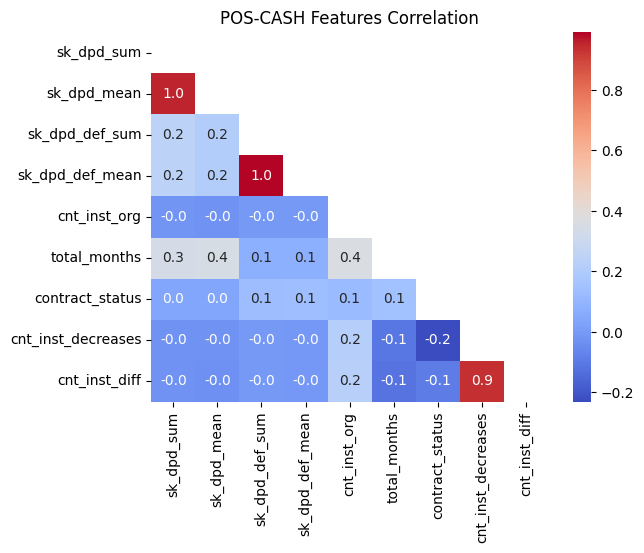

In [16]:
pos_corr = pos_agg_df.set_index("sk_id_curr").copy().drop(columns=["sk_id_prev"])
pos_corr = pos_corr.corr()
triangle_mask = np.triu(pos_corr)

sns.heatmap(pos_corr, cmap="coolwarm", annot=True, fmt="0.1f", mask=triangle_mask)
plt.title("POS-CASH Features Correlation")
plt.show()

---

#### credit_card_df

contains snapshots of each monthly payment for credit card loan. 

In [7]:
cc_df = joblib.load("data/home-credit-default-risk/pkl_files/cc_df")
cc_agg_df = joblib.load("data/cc_agg_df")

In [137]:
cc_df.shape

(3227965, 22)

In [132]:
cc_df.head()

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.000000,0.0,0.000000,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.000000,0.0,0.000000,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.000000,0.0,11547.000000,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
8,2181852,367360,-4,291543.062500,292500,90000.0,289339.437500,0.0,199339.421875,130.500000,...,286831.562500,286831.562500,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.187500,225000,76500.0,111026.703125,0.0,34526.699219,6338.339844,...,197224.687500,197224.687500,3.0,9,0.0,6.0,38.0,Active,0,0


##### Handle nulls and duplications

In [156]:
cc_df.duplicated().sum()

0

In [4]:
cc_df.isnull().sum()[cc_df.isnull().sum() != 0]

amt_drawings_atm_current      605754
amt_drawings_other_current    605754
amt_drawings_pos_current      605754
amt_inst_min_regularity       264384
amt_payment_current           620093
cnt_drawings_atm_current      605754
cnt_drawings_other_current    605754
cnt_drawings_pos_current      605754
cnt_instalment_mature_cum     264384
dtype: int64

Drawing related features have nulls simultaneously, if amt_drawing and cnt_drawing \
is 0, atm, pos, and other drawing features should also be 0.

In [22]:
# amt
atm_draw = np.where(cc_df.amt_drawings_current == 0, 0, cc_df.amt_drawings_atm_current)

pos_draw = np.where(cc_df.amt_drawings_current == 0, 0, cc_df.amt_drawings_pos_current)

other_draw = np.where(
    cc_df.amt_drawings_current == 0, 0, cc_df.amt_drawings_other_current
)

cc_df["amt_drawings_atm_current"] = atm_draw
cc_df["amt_drawings_pos_current"] = pos_draw
cc_df["amt_drawings_other_current"] = other_draw

# cnt
atm_draw_cnt = np.where(
    cc_df.cnt_drawings_current == 0, 0, cc_df.cnt_drawings_atm_current
)

pos_draw_cnt = np.where(
    cc_df.cnt_drawings_current == 0, 0, cc_df.cnt_drawings_pos_current
)

other_draw_cnt = np.where(
    cc_df.cnt_drawings_current == 0, 0, cc_df.cnt_drawings_other_current
)

cc_df["cnt_drawings_atm_current"] = atm_draw_cnt
cc_df["cnt_drawings_pos_current"] = pos_draw_cnt
cc_df["cnt_drawings_other_current"] = other_draw_cnt

cc_df = cc_df.drop(columns=["amt_payment_current"])

In [6]:
cc_df.isnull().sum()[cc_df.isnull().sum() != 0]

amt_inst_min_regularity      264384
cnt_instalment_mature_cum    264384
dtype: int64

In [9]:
cc_df.loc[pd.isna(cc_df.amt_inst_min_regularity)].iloc[:, 2:]

,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,amt_payment_total_current,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
5362,-52,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
5370,-51,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
5382,-52,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
5383,-52,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
5385,-54,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838764,-35,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
3838767,-35,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
3838768,-40,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0
3838776,-35,0.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,Active,0,0


The rest of the feature with nulls are `amt_inst_min_regularity` and \
`cnt_instalment_mature_cum`, they also occur simultaneously.

They seem to occur when the client did not use the card for many instalments, \
and started to use it after some time. 

Here we would just drop the nulls, as the record when the card is not used is \
not important for our analysis.

In [23]:
cc_df = cc_df.dropna()

##### Inspect abnormal records

Some records seems to be not meaningful as after aggregation on sk_id_prev, \
these records have:

- amt_balance always equals to 0
- no drawing record for all instalment
- amt_inst_min_regularity sum equals to 0

In [24]:
no_draw_df = cc_df.groupby(["sk_id_prev", "sk_id_curr"])[
    ["amt_balance", "amt_drawings_current",
        "months_balance", "amt_inst_min_regularity"]
].agg(
    {
        "amt_balance": ["sum"],
        "amt_drawings_current": ["sum"],
        "months_balance": ["min", "count"],
        "amt_inst_min_regularity": ["sum"],
    }
)

card_auto_pay_online = no_draw_df.loc[
    (no_draw_df[("amt_balance", "sum")] == 0)
    & (no_draw_df[("amt_drawings_current", "sum")] == 0)
    & (no_draw_df[("amt_inst_min_regularity", "sum")] == 0)
    & (
        no_draw_df[("months_balance", "min")] * -1
        == no_draw_df[("months_balance", "count")]
    )
]
bprint("Records with sum(amt_balance) & sum(amt_drawings) equals to 0")
dp(card_auto_pay_online)

card_auto_pay_online_id = [i[0] for i in card_auto_pay_online.index]
card_auto_pay_online_curr_id = [i[1] for i in card_auto_pay_online.index]

bprint("Records in instalment dataframe")
dp(inst_df[inst_df.sk_id_prev.isin(card_auto_pay_online_id)])


print(
    f"There were {no_draw_df.shape[0]} credit_card records, but {len(card_auto_pay_online_id)} have sum of amt_balance equals 0 and no drawing records, this is about {round(len(card_auto_pay_online_id)/no_draw_df.shape[0], 2)*100}% of all records. While these records have payment recorded in instalment dataframe."
)


Records with sum(amt_balance) & sum(amt_drawings) equals to 0


amt_balance amt_drawings_current months_balance        \
                              sum                  sum            min count   
sk_id_prev sk_id_curr                                                         
1000083    309691             0.0                  0.0            -13    13   
1000089    161517             0.0                  0.0             -5     5   
1000186    248741             0.0                  0.0             -6     6   
1000241    360218             0.0                  0.0            -20    20   
1000339    112719             0.0                  0.0            -15    15   
...                           ...                  ...            ...   ...   
2842928    294169             0.0                  0.0            -28    28   
2843103    191663             0.0                  0.0             -9     9   
2843160    202783             0.0                  0.0             -2     2   
2843332    298901             0.0                  0.0            -26    26   
2843373    369274             0.0                  0.0            -11    11   

                      amt_inst_min_regularity  
                                          sum  
sk_id_prev sk_id_curr                          
1000083    309691                         0.0  
1000089    161517                         0.0  
1000186    248741                         0.0  
1000241    360218                         0.0  
1000339    112719                         0.0  
...                                       ...  
2842928    294169                         0.0  
2843103    191663                         0.0  
2843160    202783                         0.0  
2843332    298901                         0.0  
2843373    369274                         0.0  

[11050 rows x 5 columns]


Records in instalment dataframe


,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
159,2027498,121455,0.0,25,-2693.0,-2693.0,145.080002,145.080002
1207,1626516,141775,0.0,54,-1944.0,-1944.0,257.984985,257.984985
2148,2100713,183877,0.0,51,-1794.0,-1794.0,482.130005,482.130005
2543,1281563,141514,0.0,85,-988.0,-988.0,1487.069946,1487.069946
3448,1061571,141622,0.0,94,-537.0,-537.0,183.869995,183.869995
...,...,...,...,...,...,...,...,...
13599474,2525125,433676,0.0,92,-576.0,-576.0,191.024994,191.024994
13603240,2687505,429564,0.0,62,-1498.0,-1498.0,248.850006,248.850006
13603290,2809790,428646,0.0,115,-309.0,-309.0,1174.050049,1174.050049
13604839,1398902,424291,0.0,33,-2738.0,-2738.0,28.799999,28.799999


There were 87452 credit_card records, but 11050 have sum of amt_balance equals 0 and no drawing records, this is about 13.0% of all records. While these records have payment recorded in instalment dataframe.


Around 13% of the credit cards have `no draw records`, `the bill is always` \
`paid off` and there is `no minimum reqularity` for each instalment. This is \
abnormal, as it can mean that the customer never uses the card. \
However, payment record can be observed in the instalment dataframe.

Thus I assume that these might be people that only uses their card online and have auto-pay set up.

we would mark them with `card_auto_pay_online` after aggregation.

In [28]:
cc_df.loc[cc_df.sk_id_prev == 1389973].sort_values("months_balance")

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def,contract_stat
2002682,1000077,181153,-12,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
1431772,1000077,181153,-11,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
252608,1000077,181153,-10,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
2740284,1000077,181153,-9,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
3597506,1000077,181153,-8,0.0,45000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
1956484,1000077,181153,-7,0.0,135000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
3443515,1000077,181153,-6,0.0,135000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
2107346,1000077,181153,-5,0.0,135000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
3801904,1000077,181153,-4,0.0,135000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2
213256,1000077,181153,-3,0.0,135000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,Active,0,0,2


##### Aggregate features:

- `total_months`: total_months of the recurring credit card loan.
- `atm_draw_ratio avg`: atm draw amt/ total draw amt
- `pos_draw_ratio avg`: pos draw amt/ total draw amt
- `total_monthly_draw avg`: average monthly draw
- `credit_lim_fin_org_ratio`: last credit_limit/ initial credit_limit
- `total_still_owes`: total amount the client still owes
- `total_still_owes_int_princ_ratio`: total owe interest/ total owe 
- `total_paid`: total paid amount
- `total_interest_paid`: total interest paid (negative means client pays principal)
- `interest_rate`: in the paid amount, ratio of interest.
- `pay_owe_ratio_total`: total pay/ total owe`
- `pay_less_than_min_reg_avg`: ratio of months when client pay less than minimum.
- `sk_dpd.sum`: sum of all sk_dpd
- `sk_dpd.mean`: mean of all sk_dpd
- `sk_dpd_def sum`: sum of all sk_dpd_def
- `sk_dpd_def mean`: mean of all sk_dpd_def
- `contract_stat`: ordinal mean of contract status, lower is better. \
(1: Completed, 2: Active, .., 4: Signed ... 8: Demand)

In [40]:
cc_agg_df.loc[cc_agg_df.sk_id_prev == 1389973]

,sk_id_prev,sk_id_curr,total_months,atm_draw_ratio_avg,pos_draw_ratio_avg,total_monthly_draw_avg,credit_lim_fin_org_ratio,total_still_owes,total_still_owes_int_princ_ratio,total_paid,total_interest_paid,interest_rate,pay_owe_ratio_total,pay_less_than_min_reg_avg,sk_dpd_sum,sk_dpd_mean,sk_dpd_def_sum,sk_dpd_def_mean,contract_stat,card_auto_pay_online
19971,1389973,337855,15,0.195689,0.804311,17323.389583,5.0,231618.875,0.028789,131755.046875,-128095.796875,-0.492959,1.972227,0.066667,0,0.0,0,0.0,2.0,0


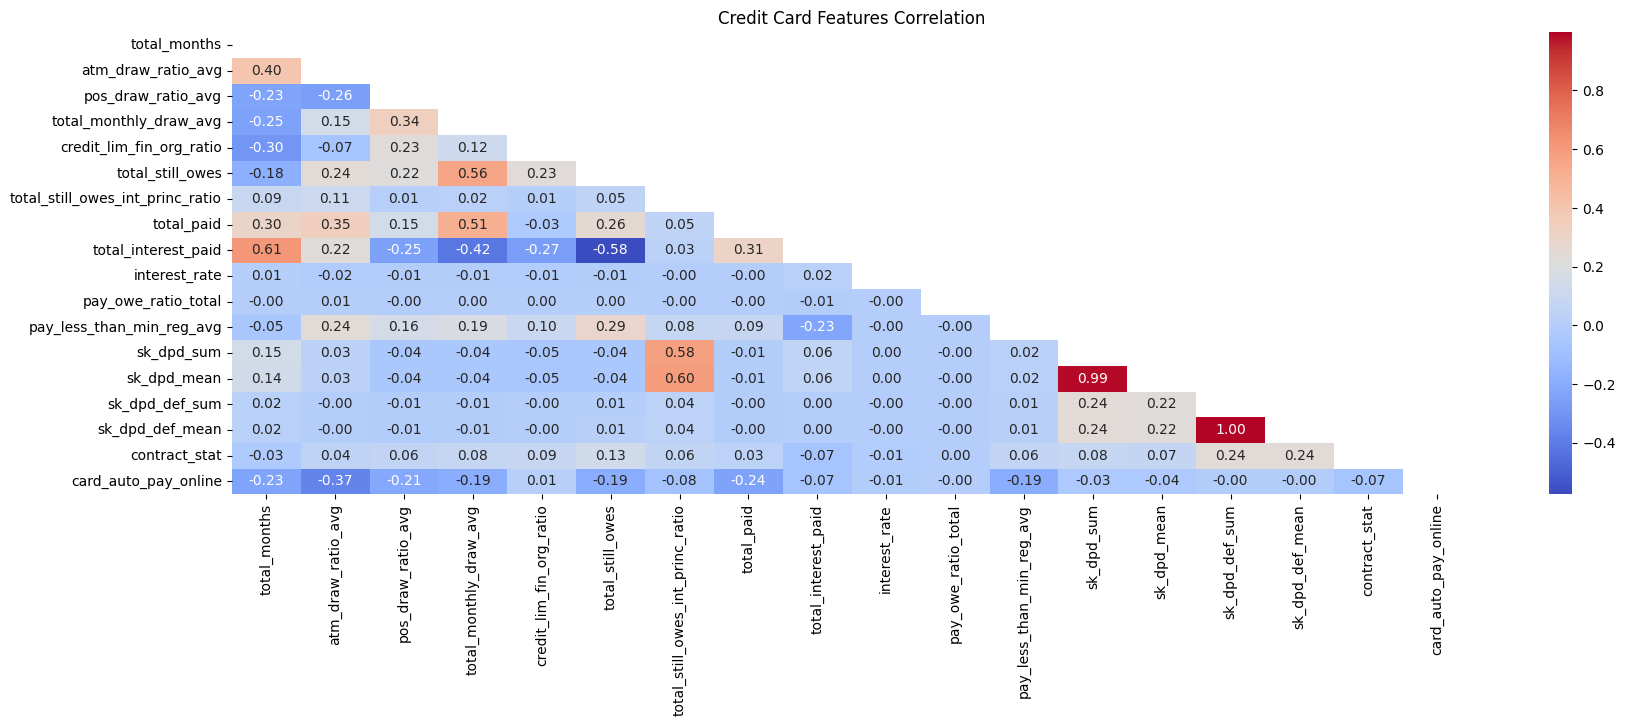

In [17]:
cc_corr = cc_agg_df.set_index("sk_id_curr").copy().drop(columns=["sk_id_prev"])
fig_size(20, 6)
cc_corr = cc_corr.corr()
triangle_mask = np.triu(cc_corr)

sns.heatmap(cc_corr, cmap="coolwarm", annot=True, fmt="0.2f", mask=triangle_mask)
plt.title("Credit Card Features Correlation")
plt.show()

---

#### prev_df

clean dataframe
- exclude rejected previous applications because our prediction target are all \
accepted applications. Aggregate the rejection data new features.

- remove meaningless rows, eg) amt_application == 0
- transform and agg previous application features on current application id

findings:
- flag_last_appl_per_contract: drop if == 'N' because it might be a redundant \
data log made on the same application.

encoding and imputing

- name_contract_type: target_encoder
- weekday_appr_process_start: target_encoder
- name_cash_loan_purpose: target_encoder

Use application result of previous application to impute the missing values, \
this would be more precise than using app_target.



In [8]:
prev_df = joblib.load("data/home-credit-default-risk/pkl_files/prev_df")
prev_agg_df = joblib.load("data/prev_cleaned_df")

In [3]:
pp = prev_df.head()
dp(pp.iloc[:, :18])
dp(pp.iloc[:, 18:])

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781


,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


##### Handle unapproved previous loans

When a previous loan contract is not approved, it has 3 possible states: \
refused, cancelled or unused.

After inspecting the data, here are some possible reasons why a loan fell in \
these 3 categories:

- `Refused`: client, limit, system, ...
- `Canceled`: redundant application, system error, ...
- `Unused offer`: personal reason, got better offer ...

> These unapproved data won't be included in the modeling data, because all our \
target data for prediction are accepted loans. Increasing them would just introduce \
bias to the model.

> Instead features would be created to label refused applications as it often \
indicates applicant related reasons and can be useful for the prediction.

In [4]:
prev_df.name_contract_status.unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

Aggregated refused previous applications to new features for sk_id_curr. 

- `rej_count`: total rejected loan the applicant had before.
- `rej_reason_mode`: the most common rejection reason in previous application

We would merge this dataframe with the aggregated prev_app dataframe.

In [5]:
prev_refused_df = prev_df.loc[prev_df.name_contract_status.isin(["Refused"])]
prev_refused_agg_df = pd.DataFrame(
    prev_refused_df.groupby("sk_id_curr").sk_id_prev.count()
)
prev_refused_agg_df = prev_refused_agg_df.rename(columns={"sk_id_prev": "rej_count"})

prev_refused_agg_df["rej_reason_mode"] = prev_refused_df.groupby(
    "sk_id_curr"
).code_reject_reason.agg(lambda i: i.mode()[0])

prev_refused_agg_df.head(3)

,rej_count,rej_reason_mode
sk_id_curr,,
100006,1,LIMIT
100011,1,LIMIT
100027,1,HC


In [6]:
prev_excluded_id = prev_df.loc[
    prev_df.name_contract_status.isin(["Refused", "Canceled", "Unused offer"])
].sk_id_prev.tolist()
prev_df = prev_df[~prev_df.sk_id_prev.isin(prev_excluded_id)]
prev_df = prev_df.drop(columns=["name_contract_status", "code_reject_reason"])

##### Handle nulls and duplications

In [7]:
prev_df.duplicated().sum()

0

In [8]:
prev_df = prev_df.replace("XNA", np.nan)
prev_df = prev_df.replace("XAP", np.nan)

prev_nulls = prev_df[
    prev_df.isnull().sum()[prev_df.isnull().sum() != 0].keys().tolist()
]

prev_nulls.isnull().mean()

amt_annuity                  0.000008
amt_credit                   0.000001
amt_down_payment             0.358766
amt_goods_price              0.042345
rate_down_payment            0.358766
rate_interest_primary        0.994593
rate_interest_privileged     0.994593
name_cash_loan_purpose       0.973959
name_payment_type            0.203337
name_type_suite              0.362717
name_client_type             0.000491
name_goods_category          0.393738
name_portfolio               0.000003
name_product_type            0.606380
name_seller_industry         0.335132
cnt_payment                  0.000003
name_yield_group             0.093004
days_first_drawing           0.037811
days_first_due               0.037811
days_last_due_1st_version    0.037811
days_last_due                0.037811
days_termination             0.037811
nflag_insured_on_approval    0.037811
dtype: float64

`rate_interest_primary` and `rate_interest_privileged` features have more than \
99% percent of th data being null, they would be dropped. 

`flag_last_appl_per_contract` is also dropped because there's only one value \
after removing rejected loan data.

It is hard to impute the rest of the nulls based on domain knowledge, we would \
leave them to the model to impute.

In [9]:
prev_df = prev_df.drop(
    columns=[
        "rate_interest_primary",
        "rate_interest_privileged",
        "flag_last_appl_per_contract",
    ]
)

##### Endcode some categorical data to ordinal

In [10]:
prev_obj_ft = prev_df.select_dtypes("object").columns
bprint("object type features:")
print(prev_obj_ft)


object type features:
Index(['name_contract_type', 'weekday_appr_process_start',
       'name_cash_loan_purpose', 'name_payment_type', 'name_type_suite',
       'name_client_type', 'name_goods_category', 'name_portfolio',
       'name_product_type', 'channel_type', 'name_seller_industry',
       'name_yield_group', 'product_combination'],
      dtype='object')


Features that can be encoded to ordinal:

- name_client_type: ['Repeater', 'New', 'Refreshed']

- name_yield_group: ['middle', 'low_action', 'high', 'low_normal']

the others are better left as categorical type


In [11]:
client_type_map = {"Repeater": 3, "Refreshed": 2, "New": 1}

name_yield_group_map = {"high": 4, "middle": 3,
                        "low_normal": 2, "low_action": 1}

prev_df["name_client_type"] = prev_df.name_client_type.apply(
    lambda i: i if pd.isna(i) else client_type_map[i]
)

prev_df["name_yield_group"] = prev_df.name_yield_group.apply(
    lambda i: i if pd.isna(i) else name_yield_group_map[i]
)

In [12]:
prev_df[["name_client_type", "name_yield_group"]].head(3)

,name_client_type,name_yield_group
0,3.0,3.0
1,3.0,1.0
2,3.0,4.0


##### Inspect linear correlation of features in previous application table

Although we would use tree based ensemble model which is not going to be impacted \
by multicollinearity between highly correlated features, removing highly correlated \
features can be still make the execution faster.

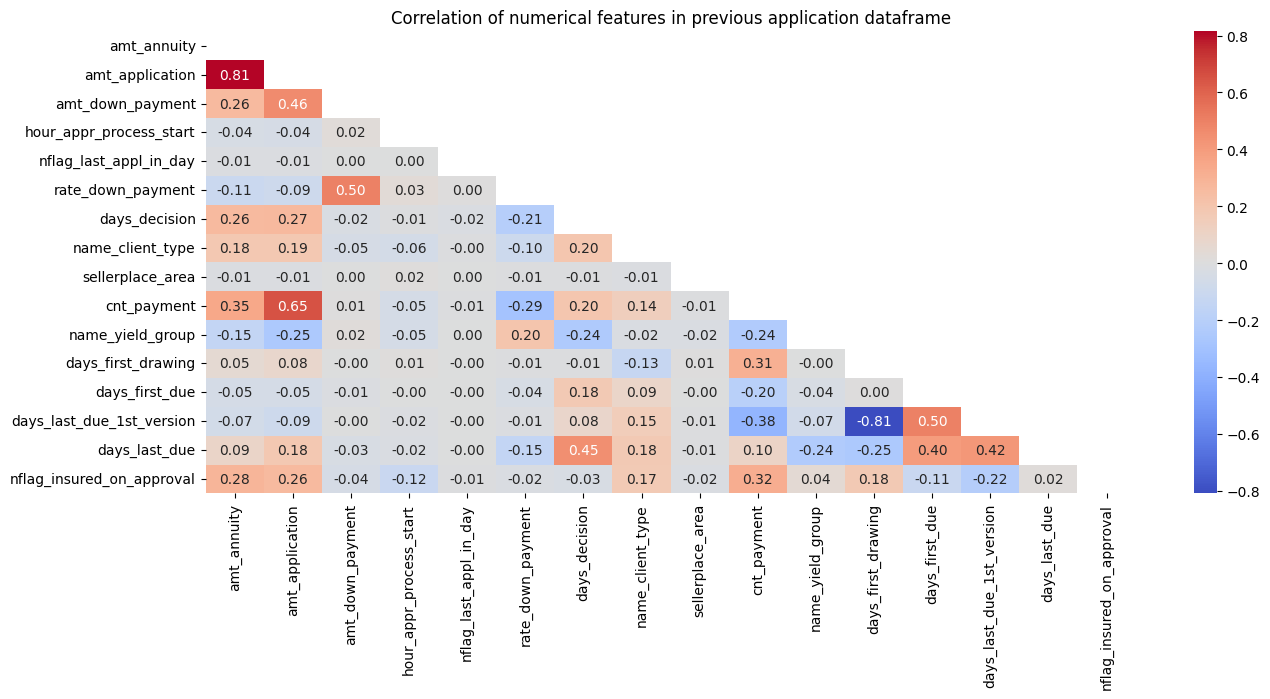

In [12]:
prev_corr = prev_agg_df.set_index("sk_id_curr").copy().drop(columns=["sk_id_prev"])

num_cols = prev_corr.select_dtypes(["float", "int"]).columns.tolist()

prev_corr = prev_corr[num_cols].corr()
triangle_mask = np.triu(prev_corr)

fig_size(15, 6)
sns.heatmap(prev_corr, cmap="coolwarm", annot=True, fmt=".2f", mask=triangle_mask)

plt.title("Correlation of numerical features in previous application dataframe")
plt.show()

Some features have correlation > 0.9:

- amt_goods_price - amt_credit: 0.99
- amt_goods_price - amt_application: 1
- amt_application - amt_credit: 0.96

- days_termination - days_last_due: 0.93

> We would remove one feature in each pair \
> Remove: `amt_goods_price`, `amt_credit`, `days_termination`

In [14]:
prev_df = prev_df.drop(columns=["amt_goods_price", "amt_credit", "days_termination"])


In [75]:
prev_df

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_down_payment,weekday_appr_process_start,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430054,17145.0,0.0,SATURDAY,15,1,0.000000,...,35,Connectivity,12.0,3.0,POS mobile with interest,365243.0,-42.0,300.0,-42.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,NaN,THURSDAY,11,1,NaN,...,-1,NaN,36.0,1.0,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,NaN,TUESDAY,11,1,NaN,...,-1,NaN,12.0,4.0,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,NaN,MONDAY,7,1,NaN,...,-1,NaN,12.0,3.0,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,1.0
5,1383531,199383,Cash loans,23703.929688,315000.0,NaN,SATURDAY,8,1,NaN,...,-1,NaN,18.0,2.0,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670206,2459206,238591,Cash loans,19401.435547,180000.0,0.0,TUESDAY,13,1,0.000000,...,100,NaN,24.0,4.0,Cash Street: high,365243.0,-1802.0,-1112.0,-1112.0,0.0
1670208,1556789,209732,Cash loans,22299.390625,315000.0,NaN,THURSDAY,17,1,NaN,...,100,NaN,36.0,3.0,Cash X-Sell: middle,365243.0,-1249.0,-199.0,-919.0,1.0
1670211,2659632,249544,Consumer loans,11520.855469,105237.0,10525.5,MONDAY,12,1,0.101401,...,1370,Consumer electronics,10.0,2.0,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,0.0
1670212,2785582,400317,Cash loans,18821.519531,180000.0,NaN,WEDNESDAY,9,1,NaN,...,-1,NaN,12.0,2.0,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,1.0


The prev_df shape is reduced from (1413701, 37) to (886099, 29)

---

#### bureau_balance_df

In [9]:
bu_bal_df = joblib.load("data/home-credit-default-risk/pkl_files/bu_bal_df")
bu_bal_agg_df = joblib.load("data/bu_bal_agg_df")

In [28]:
bu_bal_df.loc[bu_bal_df.sk_id_bureau == 5715448].head()

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


##### Aggregate on months_balance, returns the mean of status.

In [14]:
bu_bal_agg_df.loc[bu_bal_agg_df.sk_id_bureau == 5715448]

,sk_id_bureau,status
15886,5029065,0.0


---

#### bureau_df

In [10]:
bu_df = joblib.load("data/home-credit-default-risk/pkl_files/bu_df")
bu_bal_agg_df = joblib.load("data/bu_bal_agg_df")
bu_agg_df = joblib.load("data/bu_agg_df")

##### Merge bu_df with bureau_balance_df

In [39]:
bu_mg_df = bu_df.merge(bu_bal_agg_df, how="left", on="sk_id_bureau")

fill nulls with 999999 for not applicable data:

In [40]:
endday_fact = np.where(
    (bu_mg_df.credit_active == "Active") & (pd.isna(bu_mg_df.days_enddate_fact)),
    999999,
    bu_mg_df.days_enddate_fact,
)

bu_mg_df["days_enddate_fact"] = endday_fact

# encode feats
bu_mg_df["credit_active"] = bu_mg_df.credit_active.apply(
    lambda i: 1 if i == "Active" else 0
)
bu_mg_df["credit_currency"] = bu_mg_df.credit_currency.apply(
    lambda i: 1 if i == "currency 1" else 0
)

In [42]:
bu_mg_df.loc[bu_mg_df.sk_id_curr == 215354]

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity,status
0,215354,5714462,0,1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.000000,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,1,1,-208,0,1075.0,999999.0,NaN,0,2.250000e+05,171342.000000,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,5714464,1,1,-203,0,528.0,999999.0,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,5714465,1,1,-203,0,NaN,999999.0,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,5714466,1,1,-629,0,1197.0,999999.0,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN
5,215354,5714467,1,1,-273,0,27460.0,999999.0,0.0,0,1.800000e+05,71017.382812,108982.617188,0.0,Credit card,-31,NaN,NaN
6,215354,5714468,1,1,-43,0,79.0,999999.0,0.0,0,4.210380e+04,42103.800781,0.000000,0.0,Consumer credit,-22,NaN,NaN
183186,215354,5714458,0,1,-1872,0,-776.0,-1203.0,NaN,0,4.945500e+05,0.000000,0.000000,0.0,Consumer credit,-696,NaN,NaN
183187,215354,5714459,0,1,-1734,0,-638.0,-1336.0,NaN,0,1.084032e+06,0.000000,NaN,0.0,Car loan,-1336,NaN,NaN
183188,215354,5714460,0,1,-1333,0,-1089.0,-987.0,NaN,0,1.021500e+05,NaN,NaN,0.0,Consumer credit,-984,NaN,NaN


##### Aggregate features:

- `total_credit_count`: total credit in the bureau
- `active_credit_count`: total active credit
- `currency_1_ratio`: currency_1 count / total currency count
- `days_credit_active_mean`: mean of days_credit
- `credit_day_overdue_mean`: mean of overdue days
- `credit_day_overdue_count`: count of records with overdue days
- `amt_credit_max_overdue_mean`: mean of max overdue amount
- `cnt_credit_prolong_mean`: mean of prolonged days
- `amt_credit_sum_mean`: mean of credit amt
- `amt_credit_sum_debt_mean`: mean of credit sum debt
- `amt_annuity_mean`: mean of annuity
- `status_mean`: mean of loan status 


In [43]:
bug_agg_df.loc[bu_agg_df.sk_id_curr == 215354]

,sk_id_curr,total_credit_count,active_credit_count,currency_1_ratio,days_credit_active_mean,credit_day_overdue_mean,credit_day_overdue_count,amt_credit_max_overdue_mean,cnt_credit_prolong_mean,amt_credit_sum_mean,amt_credit_sum_debt_mean,amt_annuity_mean,status_mean
85196,215354,11,6,1.0,-727.818182,0.0,11,25891.5,0.0,543085.9375,47410.53125,NaN,NaN


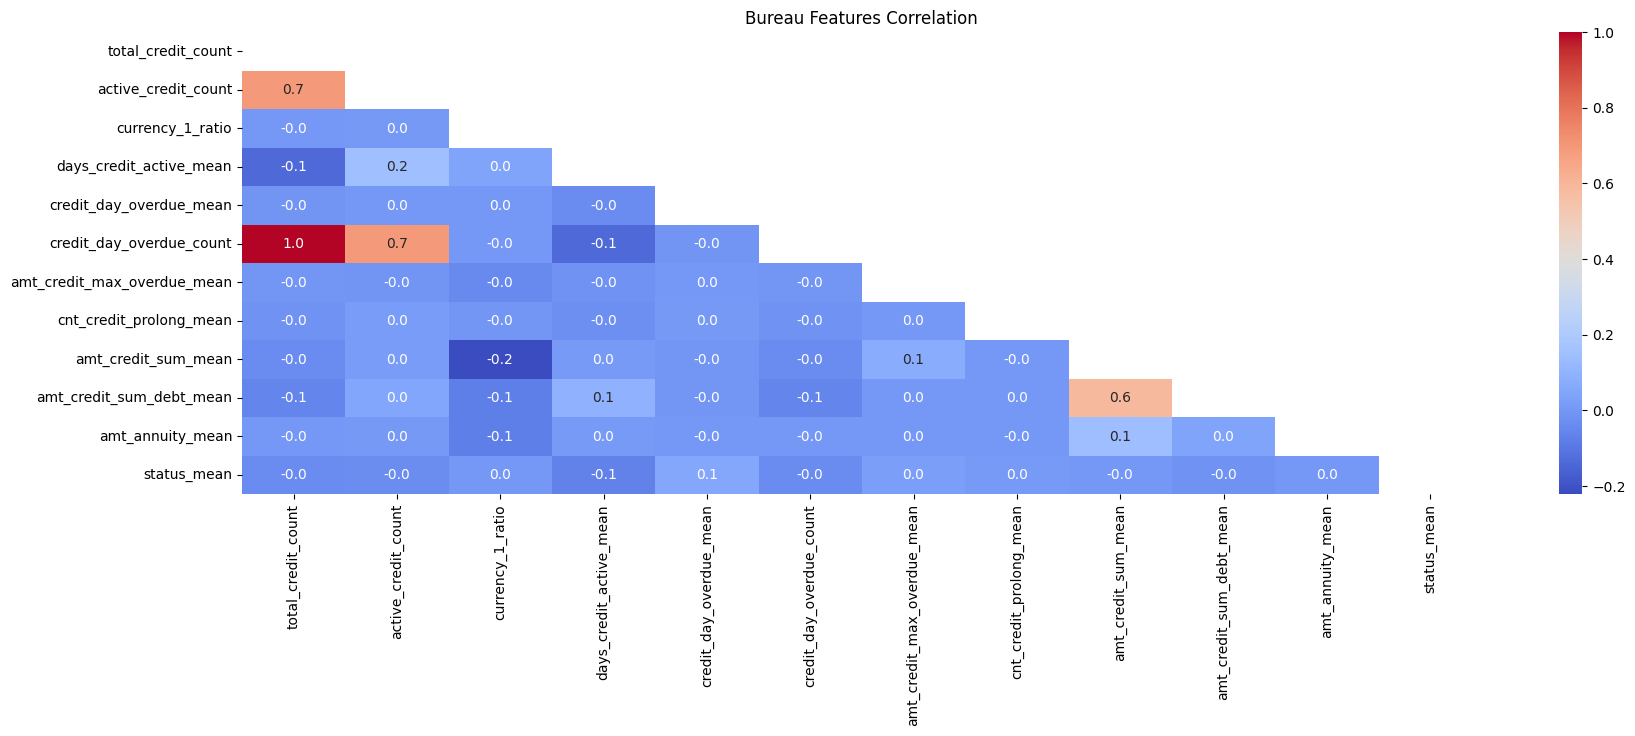

In [14]:
bu_corr = bu_agg_df.copy()
fig_size(20, 6)
bu_corr = bu_corr.corr()
triangle_mask = np.triu(bu_corr)

sns.heatmap(bu_corr, cmap="coolwarm", annot=True, fmt="0.1f", mask=triangle_mask)
plt.title("Bureau Features Correlation")
plt.show()